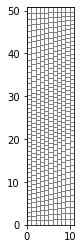

0
---------  --------------
sim_name   disu-d-af-vo-s
crossflow  False
staggered  False
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.21507120840803  18.13696542671794
avg channel  1.20996374980589  16.38420257823995
min channel  0.53418756419740   2.31330437559244
max channel  1.85425510377250  34.85533823158293
1
---------  --------------
sim_name   disu-d-af-vo-x
crossflow  False
staggered  False
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  0.98158495516016  22.81628475873673
avg channel  1.01892200788652  19.87458818052787
min channel  0.39270322475778   2.74734354130716
max channel  1.66406658587636  41.65304066451004
2
---------

In [12]:
%run ./disu_approach_resolution.ipynb
logfunc = lambda e: np.log10(e)

In [35]:
dip = np.arange(0,80,1) # For nice contours use (0,80,1)
log = np.arange(0, 4, 0.2) # For nice contours use (0,4,0.2)
Kcontrast = [10**i for i in log]
qmag_results = np.zeros((len(Kcontrast), len(dip)))
qtheta_results = np.zeros((len(Kcontrast), len(dip)))
dip_array = np.zeros((len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((len(Kcontrast), len(dip)))
Kcontrast

[1.0,
 1.5848931924611136,
 2.51188643150958,
 3.981071705534973,
 6.309573444801933,
 10.0,
 15.848931924611142,
 25.11886431509581,
 39.810717055349734,
 63.09573444801933,
 100.0,
 158.48931924611142,
 251.18864315095823,
 398.1071705534973,
 630.9573444801937,
 1000.0,
 1584.893192461114,
 2511.886431509582,
 3981.0717055349733,
 6309.573444801937]

In [36]:
for kc in range(len(Kcontrast)):
    for d in range(len(dip)):

        nlay_chan = 5                   # number of layers in channel, and number of columns in model
        Lx = 11.0                       # full horizontal width of model
        theta = dip[d]                  # angle of inclination of channel
        k_dom = 1/Kcontrast[kc]         # domain conductivity
        #theta = math.atan(0.5) * 180. / math.pi
        domain = True                   # option to include "domain" (True) or not (False)

        nrow = 1                        # model is one row deep "into the page"
        delc = 1.                       # model has unit width "into the page"

        # computed grid parameters
        if domain:
            nlay_dom_upper = nlay_chan                      # number of layers in upper domain
        else:
            nlay_dom_upper = 0
        nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
        nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
        delr = float(Lx / ncol)                             # horizontal cell size
        delz_chan = delr                                    # vertical cell size in channel
        zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
        zthick = nlay_chan * delz_chan                      # vertical thickness of channel
        zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
        zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
        zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

        ncol = int(Lx/delz_chan)

        # set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
        # the "true" top/bottom channel boundaries
        botm = np.empty((nlay, nrow, ncol))
        cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
        top_chan = zthick + 0.5 * zoffset \
            + np.linspace(0., (ncol - 1) * zoffset, ncol)
        top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
        if domain:
            # upper domain
            Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
            top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
            top = np.ones((nrow, ncol)) * Lz                # top of model
            dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
            botm[0] = top - dz                              # bottom of first layer is calculated using top
            cond[0] = k_dom
            for klay in range(1, nlay_dom_upper):
                botm[klay] = botm[klay - 1] - dz
                cond[klay] = k_dom
            # prepare to continue with channel discretization
            klaycontinue = nlay_dom_upper
        else:
            # initialize channel discretization
            Lz = zspan                                     # total height of model
            top = top_chan                                 # top of model is top of channel
            botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
            # prepare to continue channel discretization
            klaycontinue = 1
        # channel
        for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
            botm[klay] = botm[klay - 1] - delz_chan
        if domain:
            # lower domain
            dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
            for klay in range(nlay_dom_upper + nlay_chan, nlay):
                botm[klay] = botm[klay - 1] - dz
                cond[klay] = k_dom

        # plot dis grid
        delr = delr * np.ones(ncol, dtype=float)
        delc = delc * np.ones(nrow, dtype=float)
        mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                                  top=top, botm=botm)

        # run scenarios
        for i in range(3,4): # [3] = disu-d-af-vs-x
            print('kc = %i, d = %i, i = %i' %(Kcontrast[kc], dip[d], i))
            qmagmid, qangmid = simulation(i)
            qmag_results[kc][d] = abs(qmagmid - 1) # error
            qtheta_results[kc][d] = abs((qangmid - theta)/theta) # error
            
            Kcontrast_array[kc][d] = Kcontrast[kc]
            dip_array[kc][d] = dip[d]

kc = 1, d = 0, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000   0.00000000000000
mid-channel  1.00000004547196  -0.00000235285066
avg channel  1.00000000029546  -0.00000139317174
min channel  0.99999981779535  -0.00000496981470
max channel  1.00000020304138   0.00000235919774
kc = 1, d = 1, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  1.00000003648278  0.99999830639570
avg channel  1.00000000274781  0.99999897584605
min channel  0.99999986845203  0.99999630383131
max channel  1.00000014015022  

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  1.00000000027178  15.00000027912890
avg channel  0.99999999945507  15.00000010476396
min channel  0.99999999362668  14.99999985443835
max channel  1.00000000632861  15.00000029410950
kc = 1, d = 16, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  1.00000000159569  16.00000022895886
avg channel  1.00000000069432  16.00000010576206
min channel  0.99999999622031  15.99999983619618
max channel  1.00000000710619  16.00000024748

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.00000000694258  29.00000082464409
avg channel  1.00000000000890  29.00000033214229
min channel  0.99999991537901  28.99999691013631
max channel  1.00000009296313  29.00000308149898
kc = 1, d = 30, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00000000455258  30.00000066920720
avg channel  0.99999999942859  30.00000027695416
min channel  0.99999993051687  29.99999749362567
max channel  1.00000007512857  30.00000258207

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  0.99999999777186  43.99999999630902
avg channel  0.99999999881898  44.00000002330238
min channel  0.99999996211923  43.99999794511805
max channel  1.00000003804499  44.00000229235035
kc = 1, d = 45, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79056941288238  63.43494857615498
avg channel  0.82203706616523  60.38749726475734
min channel  0.79056940838287  44.99999956027194
max channel  1.00000000750432  63.43494892903


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  0.99999999855166  56.99999996348674
avg channel  1.00000000034486  56.99999994752646
min channel  0.99999999584846  56.99999924040794
max channel  1.00000001189532  57.00000015487873
kc = 1, d = 58, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  0.99999999914485  57.99999998225656
avg channel  1.00000000016749  57.99999994761508
min channel  0.99999999673490  57.99999957748245
max channel  1.00000000607741  58.00000010320657
kc = 1, d = 59, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True


---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  72.00000000000000
mid-channel  1.00000000420684  72.00000001125456
avg channel  1.00000000025632  72.00000008258435
min channel  0.99999999190807  71.99999964766620
max channel  1.00000000689703  72.00000093486156
kc = 1, d = 73, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  73.00000000000000
mid-channel  1.00000000023967  73.00000006359978
avg channel  1.00000000014018  73.00000001968912
min channel  0.99999999650717  72.99999921443825
max channel  1.00000000415340  73.00000023701

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  1.00010594893257  5.98417390460774
avg channel  0.97723973938803  5.84405612525192
min channel  0.87992645122316  5.28011818993086
max channel  1.00017758221727  6.05055963848358
kc = 1, d = 7, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  7.00000000000000
mid-channel  1.00014134906021  6.97935179406987
avg channel  0.97717869838067  6.81664900838191
min channel  0.88024704204750  6.15504962238000
max channel  1.00023121912471  7.05706819674158
kc = 1, d =

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  1.00116769146526  19.87270979587151
avg channel  0.97457443309984  19.45558126098627
min channel  0.88296872334279  17.58000365405632
max channel  1.00161020563551  20.11882595758262
kc = 1, d = 21, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  21.00000000000000
mid-channel  1.00129660707819  20.86191663375352
avg channel  0.97423331417578  20.42932872579980
min channel  0.88303854594841  18.47174857537599
max channel  1.00176645087137  21.12372834152


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.00348114175249  32.72773657269062
avg channel  0.96865277852335  32.16910253654076
min channel  0.88216811942337  29.44076206259987
max channel  1.00413615847670  33.22173260142714
kc = 1, d = 34, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.00371381962655  33.71795400722797
avg channel  0.96807171852075  33.15374018761581
min channel  0.88196606428465  30.38056807697292
max channel  1.00436573922334  34.23446542915898
kc = 1, d = 35, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True


---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  1.00830573462414  46.70425288517588
avg channel  0.94607533235573  46.84813276375056
min channel  0.82837706621588  42.69007115617242
max channel  1.00830573462414  51.25406958122621
kc = 1, d = 48, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  1.00932824356866  47.69024278990469
avg channel  0.94581451653603  47.79274798458639
min channel  0.83057051691427  43.68489257916849
max channel  1.00932824356866  52.21026881373


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.02727809405852  60.52476437416467
avg channel  0.93856910959779  60.18694415427775
min channel  0.85168312557780  56.28981909740943
max channel  1.02727809405852  64.93584915850771
kc = 1, d = 62, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  62.00000000000000
mid-channel  1.02843353598155  61.49086465505686
avg channel  0.93775518610911  61.15928537905943
min channel  0.84952090281023  57.21285446597955
max channel  1.02843353598155  65.94175611680218
kc = 1, d = 63, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True


kc = 1, d = 75, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  75.00000000000000
mid-channel  0.95941018391857  80.32767419302613
avg channel  0.91938213368018  74.20448636027126
min channel  0.82480579648704  66.43692798859396
max channel  1.00637771896905  80.32767419302613
kc = 1, d = 76, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  76.00000000000000
mid-channel  0.93853485152962  80.34303632826484
avg channel  0.90836835016641  77.17226196452769
min channel  0.81837717356226  69.73639867570277
max channel  0.99653955


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  1.00027831859618  7.96378085133107
avg channel  0.95639772783721  7.59217531199860
min channel  0.77605290939961  6.18982194966959
max channel  1.00047888441373  8.09873690758952
kc = 2, d = 9, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  9.00000000000000
mid-channel  1.00035064461570  8.95565703548241
avg channel  0.95620804893598  8.53944482164357
min channel  0.77644674003736  6.95808157109259
max channel  1.00059338347389  9.10769417155128
kc = 2, d = 10, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  ----

kc = 2, d = 23, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  23.00000000000000
mid-channel  1.00250936419052  22.78221080743738
avg channel  0.94993441932456  21.83132748107871
min channel  0.77914020511446  17.92979134692676
max channel  1.00343977004354  23.21980502833420
kc = 2, d = 24, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  1.00275654307295  23.76704312941229
avg channel  0.94923108486709  22.78655987370508
min channel  0.77910065029157  18.74360465290092
max channel  1.00372715

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.00712155720425  36.59257895041763
avg channel  0.93734379359857  35.35576849531014
min channel  0.77601568383273  29.89594702108654
max channel  1.00819467087574  37.47139793616124
kc = 2, d = 38, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.00752702964130  37.58464293066552
avg channel  0.93624340406681  36.33757194790202
min channel  0.77562782110363  30.80833087309259
max channel  1.00856336198131  38.49874166567

kc = 2, d = 51, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  1.02193668109443  50.48242900760341
avg channel  0.89913045615675  50.30459467335237
min channel  0.69833160773432  42.73552943883622
max channel  1.02193668109443  60.45191579657099
kc = 2, d = 52, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  1.02437867583701  51.46092645457557
avg channel  0.89856951937419  51.17418377937229
min channel  0.70181702191681  43.71905146283793
max channel  1.02437867


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  1.02132596873293  66.57111313294506
avg channel  0.86849229408961  64.03083084640663
min channel  0.71531569229184  55.38438984238464
max channel  1.02312172188031  74.18452054223121
kc = 2, d = 65, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.02180608158253  67.47257334332311
avg channel  0.86797602125101  64.73301566857769
min channel  0.71137276953834  55.94454061722071
max channel  1.02472201257404  74.74740214696853
kc = 2, d = 66, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True



SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  78.00000000000000
mid-channel  0.81782159675542  83.97653726071060
avg channel  0.80042632484058  76.22407299234958
min channel  0.68149271226308  57.97573808176756
max channel  0.99303646034244  86.93112749973938
kc = 2, d = 79, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  79.00000000000000
mid-channel  0.70678130745238  82.07724014977691
avg channel  0.71103425061953  83.29403161638685
min channel  0.53364081716845  69.84417725075483
max channel  0.99703031039856  92.09149276181931
kc = 3, d = 0, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
-

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  1.00068405987656  11.92991479429792
avg channel  0.93803104889777  11.13275316349412
min channel  0.69364818308483   8.27643198606381
max channel  1.00118651682281  12.14410506681579
kc = 3, d = 13, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  13.00000000000000
mid-channel  1.00080969587418  12.91966041899360
avg channel  0.93759355712162  12.06058792534620
min channel  0.69391075701155   8.96866021392267
max channel  1.00137789597686  13.15258212171

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  1.00368849054789  25.74863558130409
avg channel  0.92794558522811  24.21008470258728
min channel  0.69442496061831  18.34513559309333
max channel  1.00502642417363  26.29554322149916
kc = 3, d = 27, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  1.00401157655429  26.73425608087494
avg channel  0.92691235890384  25.15540260444327
min channel  0.69423813291204  19.10576793839805
max channel  1.00538344608517  27.31272548286


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.00885384326392  38.60499979423598
avg channel  0.91182042880854  36.69684126453910
min channel  0.69013716682499  28.92971187622157
max channel  1.01007145036626  39.63143582986223
kc = 3, d = 40, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.00930752010752  39.60143945207189
avg channel  0.91037504040754  37.67836048657308
min channel  0.68969965380877  29.81710384502743
max channel  1.01045244745980  40.66706042556675
kc = 3, d = 41, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True


---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  1.03370641454124  52.30149490852764
avg channel  0.86320699237210  51.59467858193214
min channel  0.60153859833703  41.26985337339585
max channel  1.03370641454124  67.39884678102683
kc = 3, d = 54, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  1.03747350934635  53.25285959125996
avg channel  0.86251180406343  52.38197797895111
min channel  0.60585600540943  42.21577625957510
max channel  1.03747350934635  68.08042522322


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  66.00000000000000
mid-channel  1.02692090458626  69.29224043996155
avg channel  0.82411843636127  64.72000196198778
min channel  0.61324631689784  51.66630771919458
max channel  1.03135948662056  79.91938610751903
kc = 3, d = 67, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  1.02852574831058  70.13122005685796
avg channel  0.82343636290720  65.19680407176922
min channel  0.60875709268707  51.95733745741302
max channel  1.03552488761757  80.35389444500873
kc = 3, d = 68, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True


---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000   0.00000000000000
mid-channel  0.99999998427326   0.00000381408238
avg channel  1.00000000359568   0.00000140192140
min channel  0.99999972553415  -0.00000085007300
max channel  1.00000033099290   0.00000438759441
kc = 6, d = 1, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  1.00000846621036  0.99878005413531
avg channel  0.92725575833336  0.91279553729523
min channel  0.62744455930892  0.63517479427498
max channel  1.00002496112823  1.01505576946984
kc =

kc = 6, d = 14, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  1.00089076260748  13.92642944784734
avg channel  0.92369013715253  12.76629399763788
min channel  0.63122559239528   8.82155793557018
max channel  1.00161858123968  14.14741301516731
kc = 6, d = 15, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  1.00103582174795  14.91730805259563
avg channel  0.92307562391398  13.68108394175054
min channel  0.63135612917737   9.46228160406990
max channel  1.00184045

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  1.00381897433803  26.78495302708547
avg channel  0.91192335866340  24.77231795490496
min channel  0.63059206971024  17.54681116797462
max channel  1.00535568219025  27.30798331250188
kc = 6, d = 28, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00413693826533  27.77341534328146
avg channel  0.91069806260834  25.70982362289548
min channel  0.63034420203993  18.26321500821284
max channel  1.00570053685422  28.32791697345

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.00908058400796  40.68026558828998
avg channel  0.89152238128182  38.17824199194831
min channel  0.62557805077565  28.49920774723754
max channel  1.01018028592599  41.71977978335244
kc = 6, d = 42, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.00947950084482  41.68104541803645
avg channel  0.88985389278464  39.16265229203348
min channel  0.62516616274180  29.37182722493876
max channel  1.01046567891629  42.75828582781

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  1.04560449429844  54.05714361719368
avg channel  0.83729587815975  52.62175051111051
min channel  0.53832196039542  40.30520490206677
max channel  1.04560449429844  73.73709812786007
kc = 6, d = 56, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  56.00000000000000
mid-channel  1.05052296370689  54.96903438477180
avg channel  0.83555333538544  53.43451479353021
min channel  0.54181430156755  41.20149139022429
max channel  1.05052296370689  74.66463258833


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.03512446635675  71.55689365338095
avg channel  0.79319791461405  64.48082592007721
min channel  0.53030789620716  47.64136957785029
max channel  1.04342656990995  83.65742065535019
kc = 6, d = 69, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.03946614981525  72.55346484093964
avg channel  0.79254620536577  64.88288195709097
min channel  0.52409144690915  47.92783959139121
max channel  1.05105395235706  83.92836715641360
kc = 6, d = 70, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True



SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  1.00001841435593  1.99760611129884
avg channel  0.91808117857163  1.79941706453405
min channel  0.58424298383918  1.17731955091452
max channel  1.00005562961403  2.02325688807413
kc = 10, d = 3, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  1.00003575573088  2.99563704254623
avg channel  0.91801790479378  2.69863541952797
min channel  0.58451849449239  1.76337390315909
max channel  1.00010277997133  3.03379137405661
kc = 10, d = 4, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  ---


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  1.00104286461411  15.93320184715849
avg channel  0.91266124299170  14.41424182094530
min channel  0.58668140325540   9.44117843422046
max channel  1.00198595039151  16.13594334251104
kc = 10, d = 17, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  17.00000000000000
mid-channel  1.00119481032952  16.92595536665790
avg channel  0.91188261516341  15.32154792685150
min channel  0.58668754705348  10.05064089661584
max channel  1.00221785367478  17.14435798617752
kc = 10, d = 18, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00417670514774  29.81652328385719
avg channel  0.89721589115846  27.29695963053953
min channel  0.58447219976401  18.51615129374368
max channel  1.00583319256908  30.34083294456508
kc = 10, d = 31, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  31.00000000000000
mid-channel  1.00447110768924  30.80858590136526
avg channel  0.89577129627939  28.23643397896659
min channel  0.58415382576442  19.22178605804020
max channel  1.00612377250763  31.3650281828

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.00841945005730  43.77277902867034
avg channel  0.87412687866935  40.78213168568054
min channel  0.57941655338864  29.44419117100173
max channel  1.00905143592476  44.79000408101708
kc = 10, d = 45, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79610427734462  63.26988766795702
avg channel  0.68129932228038  60.68212723592386
min channel  0.43251211377342  29.98095605991061
max channel  0.99772710944777  73.8411620154


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  1.05770527772204  55.72147445434798
avg channel  0.81835691851750  53.59146535276209
min channel  0.49998109781633  39.77497077742011
max channel  1.05770527772204  79.34772068566011
kc = 10, d = 58, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  1.06351790758089  56.58339330839718
avg channel  0.81750588208417  54.24942287689159
min channel  0.50478128792021  40.03326632402204
max channel  1.06351790758089  79.74218655718687
kc = 10, d = 59, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  71.00000000000000
mid-channel  1.05663990134138  75.31368328237738
avg channel  0.77289094883669  64.58371114867766
min channel  0.45945605642105  45.07257881021909
max channel  1.07302611197137  86.82587234832113
kc = 10, d = 72, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  72.00000000000000
mid-channel  1.01761454118270  87.79014024819770
avg channel  0.76142720014365  68.92180617338339
min channel  0.48703656483284  43.00259351474429
max channel  1.03314872245733  87.79014024819770
kc = 10, d = 73, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  1.00007088758504  4.99338515763759
avg channel  0.91138643631668  4.45242183778143
min channel  0.55524663008878  2.78292782782319
max channel  1.00021846914685  5.03896214050751
kc = 15, d = 6, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  1.00010235757837  5.99117578455565
avg channel  0.91115942652253  5.34308540316849
min channel  0.55541313086636  3.33868430858034
max channel  1.00030437104332  6.04538223799646
kc = 15, d


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  1.00130534734107  18.93971270300565
avg channel  0.90334279663757  16.99431174576486
min channel  0.55592075512475  10.75720118425429
max channel  1.00251856641079  19.12990220210594
kc = 15, d = 20, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  1.00146495949834  19.93409075626628
avg channel  0.90236165914084  17.90037039341481
min channel  0.55580530653086  11.35552626082603
max channel  1.00275094705045  20.13974210278249
kc = 15, d = 21, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.00418129909824  32.85598088929920
avg channel  0.88518162023650  29.90867027977682
min channel  0.55255781624765  19.76464286093453
max channel  1.00579386559343  33.37395343557131
kc = 15, d = 34, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.00441366037255  33.85131839386801
avg channel  0.88356582316037  30.85433874739584
min channel  0.55221610332100  20.47399919266518
max channel  1.00598400130763  34.4011375367

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  1.01187595951005  46.62992965190818
avg channel  0.81131618512110  47.23306429666692
min channel  0.41444513882063  30.25865467375210
max channel  1.01187595951005  79.28593658298526
kc = 15, d = 48, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  1.01477837314673  47.53523218402215
avg channel  0.81143711340123  47.81489256736883
min channel  0.42064069740756  31.02556744798364
max channel  1.01477837314673  79.5956335362

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.08211608159981  58.89449990540508
avg channel  0.80406572730734  55.68721151881625
min channel  0.48857685392569  39.29246240613115
max channel  1.08211608159981  83.78012015477363
kc = 15, d = 62, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  62.00000000000000
mid-channel  1.08770348352112  59.67405253996906
avg channel  0.80280303486017  56.36501820920513
min channel  0.49283119488684  39.56148677182199
max channel  1.08770348352112  84.1283850530

kc = 15, d = 76, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  76.00000000000000
mid-channel  0.82634442190736  88.78033832129036
avg channel  0.72791461272143  77.78969070820624
min channel  0.50625155782160  52.90740552142772
max channel  0.97176329853138  89.17047807764288
kc = 15, d = 77, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  77.00000000000000
mid-channel  0.76362456497643  88.79822640204432
avg channel  0.70171207594349  74.90799337282645
min channel  0.50056583130508  46.50198213047761
max channel  0.975995


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  9.00000000000000
mid-channel  1.00019846038519  8.98938906052687
avg channel  0.90585183810375  7.96545282509843
min channel  0.53587253231345  4.83889641578270
max channel  1.00060971374558  9.04431785550842
kc = 25, d = 10, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  10.00000000000000
mid-channel  1.00025247993762   9.98742178528310
avg channel  0.90539649050346   8.85293789872570
min channel  0.53592394216079   5.38171506740138
max channel  1.00074174336237  10.04846200899246
kc = 25, d = 11, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
-----


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  23.00000000000000
mid-channel  1.00169693932352  22.94569200367095
avg channel  0.89443844274827  20.51728801349523
min channel  0.53483109673520  12.76705711218859
max channel  1.00318672917174  23.14357414511692
kc = 25, d = 24, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  1.00185805281898  23.94131246029588
avg channel  0.89321955572402  21.42861815369314
min channel  0.53461102656430  13.37153718219590
max channel  1.00339760355201  24.15691760485571
kc = 25, d = 25, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.00402668522396  36.89160935287681
avg channel  0.87337939137461  33.55918871346706
min channel  0.53070176984530  21.99673195271599
max channel  1.00536017787584  37.51777992960093
kc = 25, d = 38, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.00415758755245  37.89013450489254
avg channel  0.87160752621719  34.51803758393812
min channel  0.53037381460655  22.73254612242798
max channel  1.00539320137953  38.56158165956431
kc = 25, d = 39, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  1.02382031837183  50.25334106370934
avg channel  0.80410132574297  49.49200315262630
min channel  0.41940869182031  32.40069297600746
max channel  1.02382031837183  83.68192104159738
kc = 25, d = 52, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  1.02829893273477  51.15627620517682
avg channel  0.80402338873708  50.02804053985187
min channel  0.42505220214336  33.15559491457802
max channel  1.02829893273477  83.86167626958003
kc = 25, d = 53, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.01749261883133  70.92380161386788
avg channel  0.75334414445351  62.17678659829699
min channel  0.44652611697161  41.35631389471575
max channel  1.02266134944658  87.80326200824858
kc = 25, d = 66, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  66.00000000000000
mid-channel  1.02266916024906  71.22933096774663
avg channel  0.75359191399162  62.02323965037653
min channel  0.44178748607548  40.73208489077957
max channel  1.03347131977310  88.0060845755


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  78.00000000000000
mid-channel  0.57848046942099  89.03563057059874
avg channel  0.63249703486641  68.05851717549862
min channel  0.50069573715967  27.84236164145598
max channel  0.97874070390726  90.36638695339258
kc = 25, d = 79, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   79.00000000000000
mid-channel  0.14871334553552   83.88615819089301
avg channel  0.25565960429659   87.96508891123779
min channel  0.07952322095344   80.57127899373401
max channel  0.98268522508293  103.21923774003284
kc = 39, d = 0, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d    

kc = 39, d = 13, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  13.00000000000000
mid-channel  1.00039823971644  12.98895813686706
avg channel  0.90082141713896  11.47377898702693
min channel  0.52283184218646   6.86783720171261
max channel  1.00114406140788  13.04384969972542
kc = 39, d = 14, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  1.00047497480611  13.98741817250319
avg channel  0.90012929595072  12.36255377766226
min channel  0.52277756344163   7.41063489990242
max channel  1.001306

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  1.00188566101446  25.95703238891787
avg channel  0.88752860038740  23.17771441338426
min channel  0.52072325355798  14.29681455459301
max channel  1.00350207551205  26.17387942679038
kc = 39, d = 27, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  1.00202680772848  26.95373752746387
avg channel  0.88614365486418  24.09519920406036
min channel  0.52045121674869  14.91164984772437
max channel  1.00366736035209  27.1957442899

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.00335129526423  39.92563713904902
avg channel  0.86460433005029  36.34226123774076
min channel  0.51644789214824  23.75963593884860
max channel  1.00431571378094  40.66906293089700
kc = 39, d = 41, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.00335924719279  40.92612496616616
avg channel  0.86274838398734  37.31241265667914
min channel  0.51616131653816  24.51901448221822
max channel  1.00419397691409  41.7188033792


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  1.03165559684288  52.03171643486570
avg channel  0.79935324810289  50.47241585476085
min channel  0.41877475519260  33.22425653881270
max channel  1.03165559684288  86.07737872089541
kc = 39, d = 54, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  1.03703345592260  52.91508578353707
avg channel  0.79918575678689  50.98384957806663
min channel  0.42411262299577  33.95999391358666
max channel  1.03703345592260  86.21659004869824
kc = 39, d = 55, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

kc = 39, d = 67, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  1.02678751736118  71.81601555729765
avg channel  0.74883882880938  61.50091949193122
min channel  0.42434884669804  39.20772300352915
max channel  1.04761703220177  88.76972607545885
kc = 39, d = 68, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.03523474333377  72.41525460637982
avg channel  0.74916121352929  61.38194230169410
min channel  0.41777117115837  38.65846008793890
max channel  1.059267

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000   0.00000000000000
mid-channel  0.99999999596314   0.00000012083177
avg channel  1.00000000101372  -0.00000000505768
min channel  0.99999988749789  -0.00000078321162
max channel  1.00000014199529   0.00000082560425
kc = 63, d = 1, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  1.00000173505617  0.99981796503787
avg channel  0.90308483745231  0.87758414605396
min channel  0.51421096823461  0.51538589032815
max channel  1.00001037432169  1.00272933038001
kc 

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  1.00042204439244  13.99387211859051
avg channel  0.89826218561175  12.32965527476446
min channel  0.51429227851472   7.30240215098430
max channel  1.00125817262817  14.03477190562168
kc = 63, d = 15, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  1.00049817714486  14.99296627243937
avg channel  0.89750407366735  13.21796813002492
min channel  0.51419961504503   7.84170993853637
max channel  1.00141999152002  15.0390197855

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00190376712848  27.96879688163933
avg channel  0.88268734003972  24.96025881870485
min channel  0.51152671782627  15.32348437592856
max channel  1.00355339580395  28.22017287696718
kc = 63, d = 29, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.00201702629079  28.96631323855286
avg channel  0.88119912258883  25.88271854890804
min channel  0.51123361318446  15.94688127660498
max channel  1.00367018405173  29.2469759987

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.00249240466649  41.95166925179619
avg channel  0.85868711254192  38.21648711000135
min channel  0.50735798889940  24.95949147794569
max channel  1.00313398810211  42.77947566762283
kc = 63, d = 43, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  43.00000000000000
mid-channel  1.00238694436528  42.95304877069839
avg channel  0.85679222345337  39.19458358939934
min channel  0.50711308642676  25.73498136037009
max channel  1.00286709417656  43.8320061562

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  56.00000000000000
mid-channel  1.04773711529148  54.62143407504870
avg channel  0.79439994985154  52.04871922582298
min channel  0.42695028503057  34.92584579552466
max channel  1.05001909816335  87.82454600635228
kc = 63, d = 57, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  1.05412372927446  55.46197065758584
avg channel  0.79399611725977  52.55940248883474
min channel  0.43186155673222  35.64072034067423
max channel  1.05690699304029  87.9032536221


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.04419905310441  73.30688635388874
avg channel  0.74643535983510  61.05543779518154
min channel  0.40284453521772  37.57279188373532
max channel  1.07318704018641  89.28135393404001
kc = 63, d = 70, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  70.00000000000000
mid-channel  1.05560284420105  74.39062799898235
avg channel  0.74649047501194  61.22183159208726
min channel  0.39416563191807  37.41036866456523
max channel  1.08350503591022  89.32434256461860
kc = 63, d = 71, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       Tru

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  1.00000949637413  2.99960268446067
avg channel  0.90177335562264  2.62778744546196
min channel  0.50908358857730  1.52940397830324
max channel  1.00006891887935  3.00495094236920
kc = 100, d = 4, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  4.00000000000000
mid-channel  1.00001801080040  3.99946584050774
avg channel  0.90161333189223  3.50414097665653
min channel  0.50911599888307  2.03980909359613
max channel  1.00011804252909  4.00638706257821
kc = 100,

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  17.00000000000000
mid-channel  1.00061627007817  16.99660461724947
avg channel  0.89460357144260  14.97489112837023
min channel  0.50849962619351   8.84907683624376
max channel  1.00170718884688  17.04331987097073
kc = 100, d = 18, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  18.00000000000000
mid-channel  1.00070405806381  17.99584492589169
avg channel  0.89366932070913  15.86736961116440
min channel  0.50834394994448   9.39631902724136
max channel  1.00187414204216  18.051435603


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00191021433367  29.97697565820089
avg channel  0.87835813264770  26.77132630803166
min channel  0.50540752206960  16.43424166535219
max channel  1.00354917182169  30.27714755818785
kc = 100, d = 31, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  31.00000000000000
mid-channel  1.00199229520767  30.97507881082630
avg channel  0.87677814485928  27.69981464967676
min channel  0.50510383350631  17.07002744352925
max channel  1.00361247886496  31.30870867425799
kc = 100, d = 32, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.00157542599430  43.97059279343794
avg channel  0.85348473186553  40.13081359963500
min channel  0.50145424390658  26.29643783321344
max channel  1.00184177539684  44.89154630885588
kc = 100, d = 45, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79148178550423  63.41471584218471
avg channel  0.65982051114117  61.26084890257117
min channel  0.36047601154777  26.94194121026491
max channel  0.99967559760118  87.936423201

kc = 100, d = 58, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  1.05988659622499  56.26063582091562
avg channel  0.79180608277560  52.98633774234217
min channel  0.43196215104460  35.99298634097661
max channel  1.06707289872807  88.70650441517137
kc = 100, d = 59, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  1.06652874069927  57.06168983285438
avg channel  0.79119925922688  53.51057425295087
min channel  0.43657861221799  36.67955796976286
max channel  1.0751


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  71.00000000000000
mid-channel  1.06625525753751  75.73220227255378
avg channel  0.74549722594508  61.31017872699415
min channel  0.38063588614642  37.09859534306498
max channel  1.09416460887100  89.65699506697290
kc = 100, d = 72, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  72.00000000000000
mid-channel  1.03071211801910  89.76939842964153
avg channel  0.73366335814185  66.69161996367120
min channel  0.41110009131144  34.98524596915686
max channel  1.03277164494598  89.76939842964153
kc = 100, d = 73, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  1.00002676809938  4.99983916722909
avg channel  0.90066933379056  4.37552666818708
min channel  0.50578515970915  2.53408098892804
max channel  1.00017551298740  5.00494521169028
kc = 158, d = 6, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  1.00004222113744  5.99991188806982
avg channel  0.90040443967906  5.25179234903434
min channel  0.50579197761381  3.04315389181444
max channel  1.00024919535974  6.00582139190401
kc = 158,

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  1.00075146743101  18.99945763117217
avg channel  0.89189771014997  16.74466007209485
min channel  0.50468312325418   9.88969279068509
max channel  1.00199805209437  19.05801368615274
kc = 158, d = 20, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  1.00084269612992  19.99878132163501
avg channel  0.89084794527282  17.64066590745511
min channel  0.50448969122458  10.44406081294608
max channel  1.00215998096570  20.069113175

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.00194200718689  32.98093935070135
avg channel  0.87265541965120  29.54253032497392
min channel  0.50097722110360  18.26763645196755
max channel  1.00348269918513  33.37989734030919
kc = 158, d = 34, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.00197554999081  33.97966223712341
avg channel  0.87095936103215  30.48165238827895
min channel  0.50067170050638  18.92857981855804
max channel  1.00346184082617  34.418057042

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  1.00620559342675  46.67323060583548
avg channel  0.79241728475606  47.50357936486369
min channel  0.37013211429679  28.14853654479630
max channel  1.00649152382404  88.74294744323900
kc = 158, d = 48, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  1.00891944247022  47.55681864695816
avg channel  0.79276523665341  47.98258528008110
min channel  0.37608723488112  28.83052757355694
max channel  1.01054511963026  88.778908296

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.07887108429913  58.58704920418872
avg channel  0.78857995779214  54.53337839480274
min channel  0.44241476029993  36.92214160563108
max channel  1.09509911626946  89.27690493086361
kc = 158, d = 62, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  62.00000000000000
mid-channel  1.08486764139719  59.33431297050629
avg channel  0.78755566294916  55.11484235820882
min channel  0.44660897820591  36.93724641306419
max channel  1.10467933325378  89.311898269

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  75.00000000000000
mid-channel  0.89387512157159  89.89564094625123
avg channel  0.76264803668242  66.66753846853767
min channel  0.48821155458267  36.08560799113769
max channel  1.02301312645904  89.89564094625123
kc = 158, d = 76, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  76.00000000000000
mid-channel  0.81267598657400  89.87334980092010
avg channel  0.70539517581080  77.69182541177339
min channel  0.45903507427035  50.23202081036461
max channel  0.97031483692266  89.915804574


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  1.00008256798042  8.00086063208029
avg channel  0.89924341177910  7.00111304801222
min channel  0.50362516762047  4.04913776538739
max channel  1.00042624766396  8.00510535145378
kc = 251, d = 9, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  9.00000000000000
mid-channel  1.00011219763856  9.00117629356822
avg channel  0.89881434692193  7.87908323565068
min channel  0.50359316981378  4.56130907929028
max channel  1.00053208998324  9.00615318382871
kc = 251, d = 10, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  22.00000000000000
mid-channel  1.00099232182178  22.00061228194470
avg channel  0.88808111474861  19.42751294199076
min channel  0.50183644660817  11.52678052109367
max channel  1.00243453676246  22.09470771914833
kc = 251, d = 23, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  23.00000000000000
mid-channel  1.00108565141638  22.99974890344762
avg channel  0.88686725665868  20.33041263475771
min channel  0.50159862830167  12.09666471283604
max channel  1.00258055120427  23.11091133252822
kc = 251, d = 24, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  36.00000000000000
mid-channel  1.00183942457499  35.98407962855297
avg channel  0.86692562673660  32.35492466963422
min channel  0.49784743562530  20.20994984736449
max channel  1.00317266423002  36.50200891824556
kc = 251, d = 37, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.00180834409548  36.98352495938595
avg channel  0.86513538907760  33.30578526568447
min channel  0.49755570191120  20.90003094672284
max channel  1.00304889006799  37.54619868642016
kc = 251, d = 38, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  50.00000000000000
mid-channel  1.01524378690215  49.33433610486777
avg channel  0.79250708537410  48.93346450795171
min channel  0.38593062428153  30.09991282876378
max channel  1.01995526048140  89.27493116646819
kc = 251, d = 51, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  1.01924537951079  50.22465210522895
avg channel  0.79267706143079  49.40125761982353
min channel  0.39151632449600  30.78788242288261
max channel  1.02486677912388  89.294378338

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  1.00327661356180  71.46346949001277
avg channel  0.73982199064209  61.88758820026134
min channel  0.42139825254454  40.41345719924399
max channel  1.03640503228333  89.76337505830850
kc = 251, d = 65, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.00781439643054  71.52362207900231
avg channel  0.74042814351366  61.54233682924831
min channel  0.41800561584593  39.58315095702199
max channel  1.03972008766962  89.769999976

kc = 251, d = 78, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  78.00000000000000
mid-channel  0.52287869250346  89.89204365945893
avg channel  0.61445821430329  66.57789612304593
min channel  0.49233816510625  24.16309835578422
max channel  0.97815556728870  90.03618508166636
kc = 251, d = 79, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   79.00000000000000
mid-channel  0.01684191611399   84.11274521614291
avg channel  0.15549600239735   88.84706840327271
min channel  0.00851586765041   81.04970738722766
max channel  


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  1.00018267405775  11.00260074068870
avg channel  0.89748607131867   9.63373217827589
min channel  0.50211484310916   5.57842650046100
max channel  1.00076623104235  11.00952421404349
kc = 398, d = 12, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  1.00022868766288  12.00303617559629
avg channel  0.89688647922478  10.51473629649245
min channel  0.50203774794607   6.09691276221979
max channel  1.00089743512411  12.01170971780848
kc = 398, d = 13, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  25.00000000000000
mid-channel  1.00123501589068  25.00040194595890
avg channel  0.88396074273941  22.13592085158891
min channel  0.49967683944562  13.22537863842178
max channel  1.00281223893926  25.14837202207770
kc = 398, d = 26, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  1.00132141212370  25.99932950504138
avg channel  0.88259354093935  23.04700711244990
min channel  0.49940542388029  13.81428446063211
max channel  1.00292761566173  26.170354156

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.00155002309188  38.98740108338225
avg channel  0.86113080490430  35.20898732663469
min channel  0.49559532824372  22.26403434641530
max channel  1.00256013098493  39.64110751470665
kc = 398, d = 40, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.00143544320734  39.98765393315502
avg channel  0.85926995288614  36.17244484816242
min channel  0.49533242128011  22.98674707911291
max channel  1.00231279618019  40.690365785

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  1.02836924425355  51.99379878399749
avg channel  0.79234543670138  50.32646770659225
min channel  0.40121287140773  32.09467143977673
max channel  1.03618997508980  89.58107637784825
kc = 398, d = 54, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  1.03375229832728  52.86719570605577
avg channel  0.79230397394964  50.79264107256489
min channel  0.40642362398827  32.78472313801635
max channel  1.04222220407811  89.595948390

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  1.02068210968686  72.04723970945099
avg channel  0.74124667436375  60.84447174558003
min channel  0.40754569295236  37.86797266933474
max channel  1.05319052538318  89.87304824016054
kc = 398, d = 68, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.03019811413347  72.59018454204715
avg channel  0.74187587313951  60.61877442253653
min channel  0.40104387945829  37.14798985054105
max channel  1.06569521279050  89.878914886

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  1.00000046954387  0.99999417576708
avg channel  0.90029035696117  0.87324944066020
min channel  0.50143886095246  0.50159438622057
max channel  1.00000760170645  1.00028871757275
kc = 630, d = 2, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  1.00000218960617  2.00002355583852
avg channel  0.90022096054971  1.74662005714840
min channel  0.50144718904215  1.00337239224093
max channel  1.00002916914411  2.00054616821001
kc = 630,


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  1.00033203523150  14.00451452758633
avg channel  0.89532181912879  12.27752641689627
min channel  0.50096181209146   7.13221107088670
max channel  1.00117386692574  14.01727678212390
kc = 630, d = 15, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  1.00039431003333  15.00488623161786
avg channel  0.89454927172767  13.16279372209753
min channel  0.50083674871645   7.66007566647223
max channel  1.00132196385870  15.02222615148562
kc = 630, d = 16, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.00151874340001  28.99778996320110
avg channel  0.87800138154602  25.79312975774623
min channel  0.49765172627433  15.60413832065478
max channel  1.00315489308066  29.24850586977729
kc = 630, d = 30, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00157881467581  29.99658937600788
avg channel  0.87645151700714  26.71698726164356
min channel  0.49735397772800  16.22377099940299
max channel  1.00320497959920  30.278766411

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.00101051443410  41.99166868565466
avg channel  0.85527452234293  38.10522734019499
min channel  0.49396482443672  24.43362895266920
max channel  1.00157778644783  42.79374374006284
kc = 630, d = 43, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  43.00000000000000
mid-channel  1.00078931290337  42.99272028418531
avg channel  0.85336832838396  39.08188442488229
min channel  0.49374590139862  25.19189562021689
max channel  1.00118316991819  43.846582855


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  1.03936477238768  53.72775187896035
avg channel  0.79189883387452  51.25206908356137
min channel  0.41079527396542  33.42192419514115
max channel  1.04905904132927  89.75390543555578
kc = 630, d = 56, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  56.00000000000000
mid-channel  1.04548632618319  54.57715227788587
avg channel  0.79014914641149  51.87237511132430
min channel  0.41574945234676  34.10724833533227
max channel  1.05601503982862  89.77352882427388
kc = 630, d = 57, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       T

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.04123723519324  73.39345291307852
avg channel  0.74206010518722  60.49886478720408
min channel  0.39258555310493  36.52732055421350
max channel  1.07801379318339  89.92660703430062
kc = 630, d = 70, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  70.00000000000000
mid-channel  1.05360645873436  74.46266186764605
avg channel  0.74229003864710  60.60991398289946
min channel  0.38363095798271  36.08571295872443
max channel  1.08925824065118  89.931000136

kc = 1000, d = 3, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  1.00000565207294  3.00014421471596
avg channel  0.89998719812339  2.61969041954912
min channel  0.50092006869175  1.50391083572539
max channel  1.00006361697119  3.00047194997710
kc = 1000, d = 4, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  4.00000000000000
mid-channel  1.00001195331401  4.00031731811619
avg channel  0.89982106816502  3.49346806817826
min channel  0.50092176500670  2.00627120303186
max channel  1.00011091634467  4

kc = 1000, d = 17, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  17.00000000000000
mid-channel  1.00052822471072  17.00598471533356
avg channel  0.89270831832748  14.93609504232835
min channel  0.49998237728015   8.71949056102059
max channel  1.00162230757284  17.03510331878048
kc = 1000, d = 18, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  18.00000000000000
mid-channel  1.00060414883929  18.00611561203849
avg channel  0.89176408465747  15.82680022638421
min channel  0.49980992309869   9.25964512042627
max channel  1.00


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00155479950271  29.99798629566552
avg channel  0.87631802283871  26.71317354385225
min channel  0.49678964438322  16.20903392803071
max channel  1.00317998192287  30.27886943287286
kc = 1000, d = 31, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  31.00000000000000
mid-channel  1.00160287764100  30.99684824333632
avg channel  0.87472641601038  27.64046474299454
min channel  0.49648895347273  16.83685016485290
max channel  1.00320709249244  31.31127941416440
kc = 1000, d = 32, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d      

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.00045210719113  43.99568702343130
avg channel  0.85131124424271  40.05829285798518
min channel  0.49299066873161  25.93934316628707
max channel  1.00065656608151  44.90074708719528
kc = 1000, d = 45, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79066572909529  63.43288407035259
avg channel  0.65762345372109  61.34391188168380
min channel  0.35423015891678  26.60313568497473
max channel  0.99996637750948  89.78837039

kc = 1000, d = 58, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  1.05837096316709  56.22312477800079
avg channel  0.78923577424668  52.83694091329912
min channel  0.42481405459003  35.42482841563649
max channel  1.07173716836707  89.86731637928170
kc = 1000, d = 59, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  1.06500857331166  57.01927903474345
avg channel  0.78868537567603  53.34271982516568
min channel  0.42938004565455  36.08684777984315
max channel  1.08

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  71.00000000000000
mid-channel  1.06517474656789  75.77461366252795
avg channel  0.74301094587597  60.88796404809736
min channel  0.37396598240488  35.98877717051420
max channel  1.09794497838494  89.96536925392061
kc = 1000, d = 72, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  72.00000000000000
mid-channel  1.03055865327104  89.97682489916922
avg channel  0.73106382968396  66.41025466359167
min channel  0.40411228697883  34.20328624368491
max channel  1.03075239871228  89.97682489


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  4.00000000000000
mid-channel  1.00001169574429  4.00035325897448
avg channel  0.89974688138296  3.49302451375621
min channel  0.50058312684503  2.00488467896894
max channel  1.00011061120860  4.00083675801009
kc = 1584, d = 5, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  1.00002115945468  5.00062000803046
avg channel  0.89952987521167  4.36715792516220
min channel  0.50057822052899  2.50786530340044
max channel  1.00016982761083  5.00146621407503
kc = 1584, d = 6, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
--------- 

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  18.00000000000000
mid-channel  1.00059988375335  18.00654815206457
avg channel  0.89168525106510  15.82511778210651
min channel  0.49945702395387   9.25400286838162
max channel  1.00177285925872  18.04337818344106
kc = 1584, d = 19, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  1.00067898450758  19.00659169075891
avg channel  0.89068442286142  16.71784722646947
min channel  0.49926906882581   9.79871332999125
max channel  1.00192684759208  19.05339316

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  32.00000000000000
mid-channel  1.00162119455085  31.99669648120718
avg channel  0.87301053414109  28.56887233454735
min channel  0.49583056845684  17.46372651173311
max channel  1.00319239048171  32.34591009133444
kc = 1584, d = 33, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.00164283168705  32.99569953306986
avg channel  0.87134240867477  29.50346715969408
min channel  0.49552830646766  18.10960318798719
max channel  1.00317011201446  33.38250864


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79063032169680  63.43364497320491
avg channel  0.65753329577137  61.34744154111667
min channel  0.35397998365672  26.58909124739659
max channel  0.99997875373225  89.86633268679086
kc = 1584, d = 46, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  46.00000000000000
mid-channel  1.00312410909948  45.80264912712351
avg channel  0.79003529852176  47.06773999293124
min channel  0.36010317735271  27.25270979308378
max channel  1.00345543746968  89.86856875367312
kc = 1584, d = 47, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d      

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  1.06493793769170  57.01751399353378
avg channel  0.78858261193966  53.33572531229176
min channel  0.42908605447517  36.06198797097818
max channel  1.08046779517024  89.91957847410841
kc = 1584, d = 60, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.07149144031211  57.79451587961108
avg channel  0.78789863662382  53.85870791251617
min channel  0.43351890884883  36.46675918010408
max channel  1.08951834049908  89.92302404

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  73.00000000000000
mid-channel  0.99833631194335  89.98686812287589
avg channel  0.74368531985614  66.01214577079705
min channel  0.43507577868125  35.20664444594114
max channel  1.01691313270321  89.98686812287589
kc = 1584, d = 74, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  74.00000000000000
mid-channel  0.95321855583191  89.98822772772697
avg channel  0.75268045473410  66.26227489359177
min channel  0.46571100223573  36.80447773164838
max channel  1.02195822875642  89.98822772

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  7.00000000000000
mid-channel  1.00005195576334  7.00144534772459
avg channel  0.89889122376464  6.11679104978359
min channel  0.50032937146082  3.51619744389231
max channel  1.00032461345831  7.00348497948672
kc = 2511, d = 8, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  1.00007444885330  8.00194641891447
avg channel  0.89851445774486  6.99292969840105
min channel  0.50029775263944  4.02336760460527
max channel  1.00041857830221  8.00488210131928
kc = 251


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  1.00075768104174  20.00682323735267
avg channel  0.88957774158481  17.61164422047808
min channel  0.49884323074901  10.34464450787001
max channel  1.00207581568536  20.06471630167842
kc = 2511, d = 21, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  21.00000000000000
mid-channel  1.00084166453879  21.00661798592320
avg channel  0.88846629877938  18.50888912577474
min channel  0.49862686968962  10.89978105428382
max channel  1.00222468175452  21.07781621848415
kc = 2511, d = 22, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d      

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.00163552777209  33.99543532217880
avg channel  0.86958504773190  30.44025156554192
min channel  0.49500298418212  18.75844079663004
max channel  1.00310629529150  34.42127033034809
kc = 2511, d = 35, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  35.00000000000000
mid-channel  1.00162366458601  34.99468769678654
avg channel  0.86784912717264  31.38257580131567
min channel  0.49470520701517  19.42381800189823
max channel  1.00302623049035  35.46191611

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  1.00803413027556  47.55939748101961
avg channel  0.79076461202236  48.00652237937675
min channel  0.37185372105462  28.58287824325371
max channel  1.01168469824537  89.92162774609648
kc = 2511, d = 49, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  49.00000000000000
mid-channel  1.01112526039076  48.44470567165961
avg channel  0.79107795629258  48.47067449398204
min channel  0.37763997774481  29.25774369254427
max channel  1.01613178048442  89.92471965

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  62.00000000000000
mid-channel  1.08372834665074  59.29601236630290
avg channel  0.78601831493320  54.96756842046280
min channel  0.44179750851660  36.30842021330560
max channel  1.10922418948379  89.95586357435597
kc = 2511, d = 63, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  63.00000000000000
mid-channel  1.08917295089952  60.02893410435117
avg channel  0.78485866986187  55.56480008260397
min channel  0.44582888803195  36.33473031844738
max channel  1.11956289979726  89.95814332

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  76.00000000000000
mid-channel  0.81023090994472  89.99196996163204
avg channel  0.70297837050199  77.68089233004308
min channel  0.45414094015084  49.86451413042921
max channel  0.97029580389260  89.99460378431989
kc = 2511, d = 77, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  77.00000000000000
mid-channel  0.72857122979639  89.99188642685314
avg channel  0.67427437952372  73.84967083293381
min channel  0.45482749014252  41.86646726662900
max channel  0.97437015755276  89.99696388

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  10.00000000000000
mid-channel  1.00013470412025  10.00315716287388
avg channel  0.89756427740545   8.74766607709223
min channel  0.50006150837002   5.04265150714067
max channel  1.00063560120182  10.00849514069506
kc = 3981, d = 11, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  1.00017330748698  11.00377799957465
avg channel  0.89701963811906   9.62687063700568
min channel  0.49999226110466   5.55649749188893
max channel  1.00075747125545  11.01063672


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  1.00109475418740  24.00543028876348
avg channel  0.88478013109893  21.21504838561570
min channel  0.49776120581670  12.59810614153087
max channel  1.00263366710508  24.12739457747857
kc = 3981, d = 25, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  25.00000000000000
mid-channel  1.00117797101536  25.00470082755555
avg channel  0.88345929583091  22.12283986503146
min channel  0.49749785692806  13.17809129239063
max channel  1.00275388098407  25.14764918047056
kc = 3981, d = 26, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d      

kc = 3981, d = 38, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.00145235070843  37.99393425799661
avg channel  0.86243407129809  34.23290651126362
min channel  0.49370400554639  21.47852826116888
max channel  1.00257345027848  38.59523241976801
kc = 3981, d = 39, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.00134967507986  38.99397411068329
avg channel  0.86059137983075  35.19179096695459
min channel  0.49343383941887  22.18708968637512
max channel  1.00

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  1.01861528632015  50.22138904324993
avg channel  0.79147241010411  49.39250441182305
min channel  0.38875754118292  30.60958552136585
max channel  1.02590278372117  89.95494494230103
kc = 3981, d = 52, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  1.02306104654217  51.10806336332807
avg channel  0.79159355793334  49.85190300634775
min channel  0.39419215800222  31.29242611738396
max channel  1.03125072513485  89.95634832


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  1.00178418944641  71.54823665136630
avg channel  0.73842936578206  61.83695518355911
min channel  0.41855907886198  40.28108265217812
max channel  1.03885719382244  89.98499817840425
kc = 3981, d = 65, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.00627980200563  71.59093403348201
avg channel  0.73907982451290  61.46984796131834
min channel  0.41529708832854  39.41780727884746
max channel  1.04324395483428  89.98541526885958
kc = 3981, d = 66, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d      

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  78.00000000000000
mid-channel  0.51152054312627  89.99306050905919
avg channel  0.61294411279731  66.41946941765431
min channel  0.48928016711917  23.90899235432894
max channel  0.99119211204821  90.00178473184981
kc = 3981, d = 79, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   79.00000000000000
mid-channel  0.00107760462599   84.13743132624172
avg channel  0.14359519116300   88.95144182262069
min channel  0.00054146103916   81.05812567964567
max channel  0.98162724076337  104.7

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  1.00021712175398  12.00445457407966
avg channel  0.89639873210612  10.50703801154863
min channel  0.49982147732407   6.07218352991602
max channel  1.00088658650381  12.01304525225875
kc = 6309, d = 13, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  13.00000000000000
mid-channel  1.00026699304773  13.00506192571704
avg channel  0.89573968819001  11.38887238985635
min channel  0.49972330036497   6.59186663507849
max channel  1.00102280365522  13.01559900

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  1.00125566948514  26.00404721631818
avg channel  0.88206849482587  23.03302206302093
min channel  0.49713567236978  13.76309537911869
max channel  1.00286005260580  26.16983279937245
kc = 6309, d = 27, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  1.00133153783756  27.00312205869614
avg channel  0.88065049922701  23.94680367400290
min channel  0.49685495042020  14.35740636366095
max channel  1.00295547121925  27.19404641

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.00120960965769  39.99452522606531
avg channel  0.85870619627963  36.15428763646840
min channel  0.49308590563775  22.90398516260521
max channel  1.00207730642872  40.69251954499796
kc = 6309, d = 41, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.00104673682471  40.99505149621478
avg channel  0.85682563222809  37.12187950559305
min channel  0.49283937476125  23.63592472923606
max channel  1.00176781802660  41.74323995

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  1.03332792457221  52.86195273379388
avg channel  0.79158533938217  50.77226180012850
min channel  0.40462898204361  32.65682149795964
max channel  1.04310475735136  89.97432813848530
kc = 6309, d = 55, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  1.03910262361544  53.72389185245792
avg channel  0.79147223628682  51.23667783150989
min channel  0.40969776105105  33.34095646060986
max channel  1.04964783760738  89.97528643

max channel  1.05385833175170  89.99196208159155
kc = 6309, d = 68, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.02936310866380  72.60910217610410
avg channel  0.74112825787369  60.53433006919335
min channel  0.39949527867550  36.99377591277118
max channel  1.06646805510099  89.99233291476213
kc = 6309, d = 69, i = 3
---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.04079641831067  73.40227877392594
avg channel  0.74162910560978  60.44092011223297
min channel  0.39

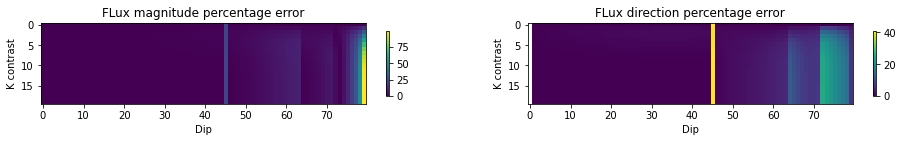

In [59]:
fig, axes = plt.subplots(1,2, figsize=(16, 3))

ax = plt.subplot(121)
cb = ax.imshow(qmag_results*100)
ax.set_title('FLux magnitude percentage error')
ax.set_xlabel('Dip')
ax.set_ylabel('K contrast')
plt.colorbar(cb, shrink = 0.4)

ax = plt.subplot(122)
cb = ax.imshow(qtheta_results*100)
ax.set_title('FLux direction percentage error')
ax.set_xlabel('Dip')
ax.set_ylabel('K contrast')
plt.colorbar(cb, shrink = 0.4)

Text(0, 0.5, 'Percentage Error (%)')

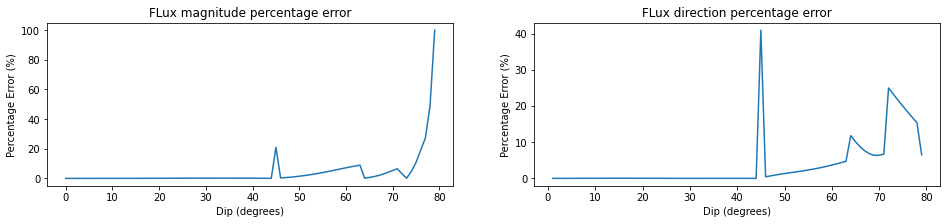

In [38]:
fig, axes = plt.subplots(1,2, figsize=(16, 3))
ax = plt.subplot(121)
ax.plot(dip,qmag_results[-1]*100)
ax.set_title('FLux magnitude percentage error')
#ax.set_xticklabels(dip)
#ax.set_xticks(np.arange(0,len(dip),1))
#ax.set_yticklabels(Kcontrast)
#ax.set_yticks(np.arange(0,len(Kcontrast),1))
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('Percentage Error (%)')

ax = plt.subplot(122)
ax.plot(dip,qtheta_results[-1]*100)
ax.set_title('FLux direction percentage error')
#ax.set_xticklabels(dip)
#ax.set_xticks(np.arange(0,len(dip),1))
#ax.set_yticklabels(Kcontrast)
#ax.set_yticks(np.arange(0,len(Kcontrast),1))
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('Percentage Error (%)')

Text(0, 0.5, 'K contrast (log)')

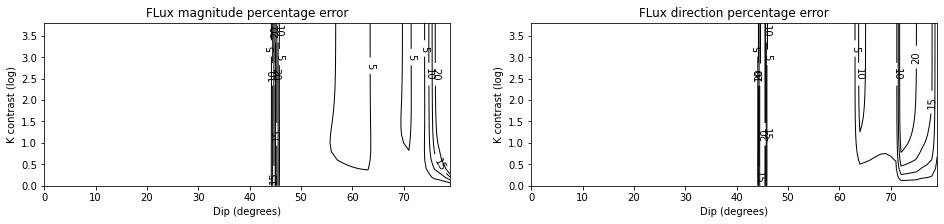

In [45]:
x = dip
y = logfunc(Kcontrast)
levels = np.arange(0, 25, 5)

fig, axes = plt.subplots(1,2, figsize=(16, 3))

# FLUX MAG
ax = plt.subplot(121)
ax.set_title('FLux magnitude percentage error')
z = qmag_results*100
CS = ax.contour(x,y,z,levels,colors='Black', linewidths=1.0)
ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('K contrast (log)')

# FLUX ANGLE
ax = plt.subplot(122)
ax.set_title('FLux direction percentage error')
z = qtheta_results*100
CS = ax.contour(x,y,z,levels,colors='Black', linewidths=1.0)
ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('K contrast (log)')